# 핵심 키워드 추출 (Keyword Extraction)

# Textrank
https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

<img src="https://3.bp.blogspot.com/-yp0Lr3ec5EY/XIs6znCcO_I/AAAAAAAAAPY/xtZxe_OYtH0xeuWsp4Qd4DQrunGMpVQmQCLcBGAs/s640/keyword-extraction-textrank.png" />

## 실습 1. 행렬 활용 


### 1) 토큰화 (Tokenization)

분석 텍스트 정제

### 2) Unique한 토큰 목록 생성

그래프 생성을 위해서 Unique한 토큰 목록 생성

In [14]:
tokens = ['딸기', '바나나', '사과', '딸기', '파인애플']
nodes = ['바나나', '사과', '파인애플', '딸기']
vocab = nodes

vocab2idx = {vocab[i]:i for i in range(0, len(vocab))} #vocab을 인덱스로 변환
idx2vocab = {i:vocab[i] for i in range(0, len(vocab))} #인덱스를 vocab으로 변환
vocab2idx

{'딸기': 3, '바나나': 0, '사과': 1, '파인애플': 2}

### 3) 그래프 생성 (weighted edge 계산)

*   TextRank는 그래프 기반 모델
*   각 단어(토큰)은 그래프의 노드(vertex) 
*   weighted_edge 행렬은 노드간 가중치 정보를 담고 있음
*   weighted_edge[i][j] 는 i번째 단어와 j번째 단어의 가중치를 의미
*   weighted_edge[i][j] 가 0인 경우는 노드간 연결이 없음을 의미
*   모든 노드는 1로 초기화

In [15]:
import numpy as np
import math
vocab_len = len(vocab)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len,vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
covered_coocurrences = []

for window_start in range(0,(len(tokens)-window_size+1)):
    window = tokens[window_start : window_start+window_size]
    for i in range(window_size) :
        for j in range(i+1, window_size) : 
            if (window[i] in vocab2idx.keys()) & (window[j] in vocab2idx.keys()) : #윈도 내 단어가 노드에 속하는 경우만 엣지로 연결
                index_of_i = window_start + i
                index_of_j = window_start + j
                
                if [index_of_i,index_of_j] not in covered_coocurrences:
                  weighted_edge[vocab2idx[window[i]]][vocab2idx[window[j]]]=1
                  weighted_edge[vocab2idx[window[j]]][vocab2idx[window[i]]]=1
                  covered_coocurrences.append([index_of_i,index_of_j])
                
for i in range(0,vocab_len):
  sumi = weighted_edge[i].sum() #각 노드별 보유한 edge 수
  weighted_edge[i] = weighted_edge[i]/sumi if sumi > 0 else 0 #edge 가중치

weighted_edge

array([[0.        , 0.5       , 0.        , 0.5       ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.33333334, 0.33333334, 0.33333334, 0.        ]], dtype=float32)

### 4) 각 노드의 score계산
각 노드와 연결된 weighted edge의 값을 합산

In [16]:
MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(0,MAX_ITERATIONS):
    prev_score = np.copy(score)
    
    for i in range(0,vocab_len):        
        summation = 0
        for j in range(0,vocab_len):
            if weighted_edge[j][i] != 0:
                summation += weighted_edge[j][i]*score[j]
                
        score[i] = (1-d) + d*(summation)
    
    if np.sum(np.fabs(prev_score-score)) <= threshold: #convergence condition
        break


### 5) 핵심 단어 추출

In [17]:
sorted_index = np.flip(np.argsort(score),0)

n = 4

print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
딸기 : 1.4668667
사과 : 0.98365426
바나나 : 0.98364776
파인애플 : 0.5656039


In [18]:
sorted_index[0]

3

---

## 실습 2. 그래프 활용 

### 1) 토큰화 (Tokenization)

분석 텍스트 정제

### 2) 그래프 생성 (weighted edge 계산)

*   TextRank는 그래프 기반 모델
*   각 단어(토큰)은 그래프의 노드(vertex) 없음을 의미
*   모든 노드는 1로 초기화

In [23]:
import numpy as np
import math
import networkx as nx

# 윈도내 동시 등장한 토큰으로 그래프를 생성
def connect(nodes, tokens) :            
    window_size = 2 # coocurrence를 판단하기 위한 window 사이즈 설정

    edges = []
    for window_start in range(0,(len(tokens)-window_size+1)):
        window = tokens[window_start:window_start+window_size]
        for i in range(window_size) :
            for j in range(i+1, window_size) : 
                if (window[i] in nodes) & (window[j] in nodes) : #윈도 내 단어가 노드에 속하는 경우만 엣지로 연결
                    edges.append((window[i], window[j]))
                    print((window[i], window[j]))
    return edges

tokens = ['ST', 'BN', 'APP', 'ST', 'PIN']
nodes = ['BN', 'APP', 'PIN', 'ST']

graph=nx.diamond_graph()
graph.clear() 
graph.add_nodes_from(list(set(nodes))) #node 등록
graph.add_edges_from(connect(nodes, tokens)) #edge 연결    

('ST', 'BN')
('BN', 'APP')
('APP', 'ST')
('ST', 'PIN')


### 3) 스코어 계산 및 핵심키워드 추출

In [24]:
scores = nx.pagerank(graph) #pagerank 계산
rank = sorted(scores.items(), key=lambda x: x[1], reverse=True) #score 역순 정렬
print("\n=== 핵심키워드 ===")
rank[:5]


=== 핵심키워드 ===


[('ST', 0.3667352990529791),
 ('APP', 0.2459279727012903),
 ('BN', 0.2459279727012903),
 ('PIN', 0.1414087555444403)]

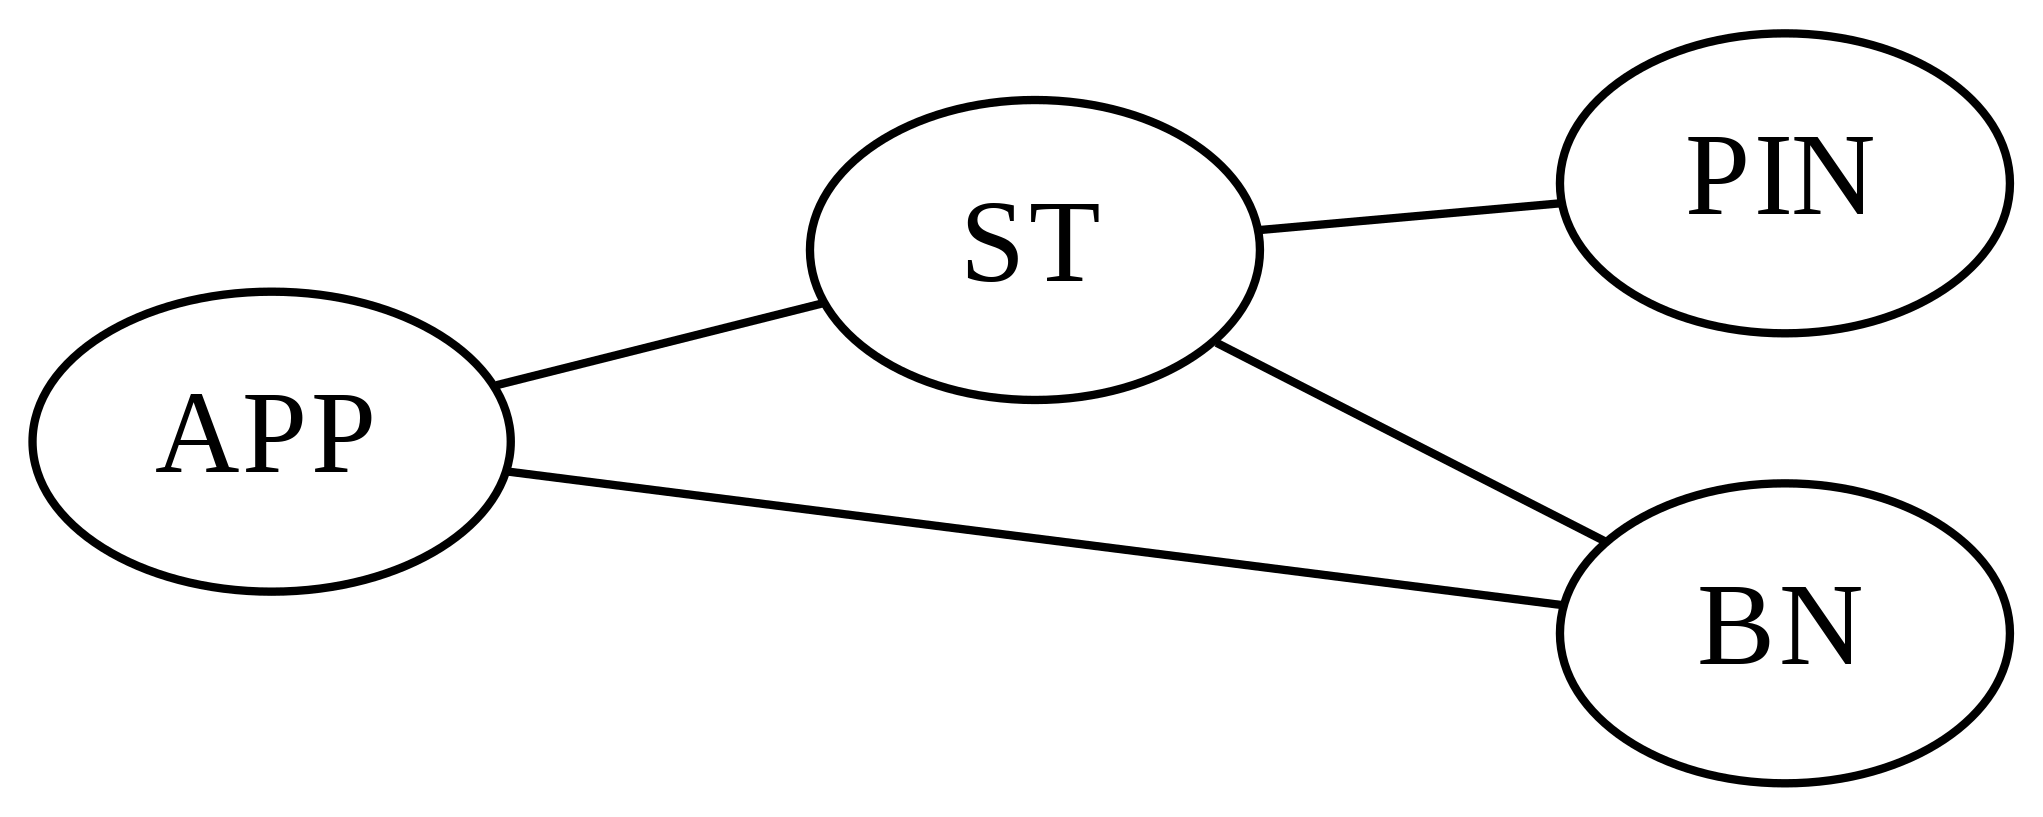

In [25]:
import networkx as nx
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

d = to_pydot(graph)
d.set_dpi(600)
d.set_rankdir("LR")
Image(d.create_png(), width=600)

---

## 실습 3. gensim 활용

In [32]:
doc = '과기정통부, 22일 유영민 장관 등 참석해 기념행사2021년까지 1516억원 투입, 5100여종 데이터 구축민간 클라우드 통한 외부연계체계도.."개방성 강화"[이데일리 이재운 기자] 국가 차원의 빅데이터 활용 시대가 열린다. 새로운 산업 창출과 기존 산업의 변화에 이르는 ‘혁신성장’을 위한 센터가 문을 연다. 10개 분야에 걸쳐 ‘데이터 경제’의 발전을 위한 정부의 청사진을 현실로 구현하는데 앞장선다는 계획이다.22일 과학기술정보통신부는 서울 중구 대한상공회의소에서 데이터 생태계 조성과 혁신 성장의 기반 마련을 위한 ‘빅데이터 플랫폼 및 센터’ 출범식 행사를 개최했다. 유영민 과기정통부 장관을 비롯해 노웅래 국회 과학기술정보방송통신위원회 위원장 등 300여명이 참가했다.◇10개 분야 100개 센터..3년간 1516억원 투입이미지: 픽사베이빅데이터는 데이터 활용을 통해 혁신성장을 이루자는 문재인 정부의 경제 성장 핵심 요소중 하나다. 문재인 대통령이 직접 올 들어 데이터 활용과 이에 따른 정보보호(보안)에 대한 중요성을 강조하기도 했다.이런 맥락 속에서 빅데이터센터는 공공과 민간이 협업해 활용도 높은 양질의 데이터를 생산·구축하고, 플랫폼은 이를 수집·분석·유통하는 역할을 담당한다. 과기정통부는 분야별 플랫폼 10개소와 이와 연계된 기관별 센터 100개소를 구축하는데 3년간 총 1516억원을 투입할 계획이며, 올해 우선 640억원 규모의 사업을 추진하고 있다.대상 분야는 △금융(BC카드) △환경(한국수자원공사) △문화(한국문화정보원) △교통(한국교통연구원) △헬스케어(국립암센터) △유통·소비(매일방송) △통신(KT) △중소기업(더존비즈온) △지역경제(경기도청) △산림(한국임업진흥원) 등으로 현재 1차 공모를 통해 72개 빅데이터 센터를 선정했고, 다음달 8일까지 2차 공모를 통해 28개를 추가 선정해 총 100개를 지원, 운영할 계획이다. 이를 통해 데이터 생태계를 혁신하고 기업의 경쟁력을 제고하는 역할을 수행한다.주요 활용 전략·사례를 보면 빅데이터 활용을 통해 ‘신(新) 시장’을 창출하는 방안을 담고 있다. 금융 플랫폼의 경우 소상공인 신용평가 고도화 등을 통해 금융 취약 계층 대상 중금리 대출이자를 2%p 절감해 연간 1조원의 신규대출을 창출할 전망이다. 유통·소비와 중소기업 플랫폼은 소상공인이나 중소기업의 폐업률 감소를, 문화 플랫폼은 문화·예술 관람률과 생활체육 참여율을 높이는 방안을 모색한다. 의료비 절감(헬스케어)과 기업의 매출 향상을 통한 산업 육성(통신·산림) 등도 눈길을 끈다.과기정통부 제공◇2021년까지 5100여종 데이터 구축..AI 알고리즘 제공도센터는 우선 분야별 데이터 부족 문제를 해소하기 위해 올해 말까지 시장 수요가 높은 1400여종 신규 데이터를 생산ㆍ구축하고, 사업이 완료되는 2021년까지 총 5100여종 양질의 풍부한 데이터를 생산·구축해 시장에 공급할 계획이다.특히 공공과 민간 사이 데이터 파일형식 등이 달라 호환이 제대로 이뤄지지 못한 문제를 해소하기 위해 개방형 표준을 적용하고, 품질관리기준도 마련해 운영한다.기업들이 실제 활용 가능한 최신 데이터를 확보하는데도 수개월이 소요된다는 문제점을 개선하기 위한 방안도 추진한다. 센터와 플랫폼 간 연계체계에는 민간 클라우드를 기반으로 활용하고, 센터에 축적된 데이터도 계속 외부와 개방·공유하며 최신·연속성을 확보한다는 계획이다.100개 센터에서 수집된 데이터를 융합·분석한 뒤 맞춤형 데이터 제작 등 양질의 데이터로 재생산하고, 기업들이 필요로 하는 데이터를 원하는 형태로 즉시 활용할 수 있도록 제공할 계획이다. 다양한 분석 도구는 물론 인공지능(AI) 학습 알고리즘도 제공해 이용자가 보다 사용하기 편리한 환경을 제공한다.이밖에 필요한 데이터를 쉽게 등록하고 검색할 수 있도록 기준을 마련하고, 데이터 보유와 관리에 대한 체계(거버넌스)를 논의하는 ‘데이터 얼라이언스’를 구성해 보다 안전하게 이용하는 방안도 마련했다.유영민 과기정통부 장관은 “오늘 출범식은 대한민국이 데이터 강국으로 가기 위한 초석을 놓은 자리”라며 “세계 주요국들보다 데이터 경제로 나아가는 발걸음이 다소 늦었지만, 빅데이터 플랫폼과 센터를 지렛대로 우리나라의 낙후된 데이터 생태계를 혁신하고 기업의 경쟁력을 한 단계 제고할 수 있도록 정책적 역량을 집중하겠다”고 밝혔다.이재운 (jwlee@edaily.co.kr)네이버 홈에서 ‘이데일리’ 뉴스 [구독하기▶]꿀잼가득 [영상보기▶] , 청춘뉘우스~ [스냅타임▶]＜ⓒ종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지＞'

In [35]:
from gensim.summarization import keywords
keywords(doc).split('\n')[:5]

['데이터', '계획이다', '빅데이터', '양질의 데이터를', '문재인']